# Emotions and CNN Project with ImageGenerator

Goal: create an CNN model which can predict the emotions and use your own pictures to actually recognize your emotions

In [25]:
# get the path of the current directory
path = os.getcwd()
path = os.path.join(path,'heavy')
print(path)

c:\Users\enric\Documents\projectsp\CNNEmotions\heavy


In [3]:
# Extracting the zipfile 
from zipfile import ZipFile

# specifity the name of the file
zippet = str("fer2013.csv.zip")

# open the zip file in read mode
with ZipFile(zippet, 'r') as zip:
    # list all the contents
    zip.printdir()

    # extract all the files
    print('extraction...')
    zip.extractall()
    print('Done!')

FileNotFoundError: [Errno 2] No such file or directory: 'heavy/fer2013.csv.zip'

Who can understand anything of this ? it is RGB images with 48x48 pixels. 

Can i trasfomr the 1st row into an image ? 

In [1]:
import pandas as pd

face = pd.read_csv('fer2013.csv')
face.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [2]:
# 1st row and the pixels image
face.loc[0,'pixels'];
# type(face.loc[0,'pixels'])
image1 = list(map(int, face.loc[0,'pixels'].split(" ")))
len(image1)

2304

as we can see the pixels are a 48x48 image since the len is 2304 = 48x48

class:  ndarray
shape:  (48, 48, 1)
strides:  (48, 1, 1)
itemsize:  1
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x19d230a2d30
byteorder:  little
byteswap:  False
type: uint8


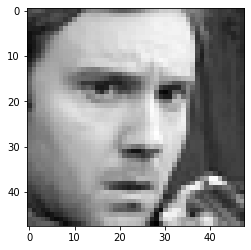

In [3]:
import re
import numpy as np
from PIL import Image
from pathlib import Path

# Open image file, slurp the lot
# contents = Path(image1).read_text()

width = 48;
height = 48;

# Make a list of anything that looks like numbers using a regex...
# ... taking first as height, second as width and remainder as pixels
# h, w *pixels = re.findall(r'[0-9]+', contents)

# Now make pixels into Numpy array of uint8 and reshape to correct height, width and depth
na = np.array(image1, dtype=np.uint8).reshape((int(48),int(48),1))

np.info(na);
# Now make the Numpy array into a PIL Image and save
#Image.fromarray(na).save("result.png")

from matplotlib import pyplot as plt
plt.imshow(na, cmap='gray')

ok, this dataset is in greyscale, so i need to go and download the original one ! at the folliwing site:

https://www.kaggle.com/datasets/deadskull7/fer2013

i was wrong. it is a greyscale images that i have to train in order to understand the emotions. Next step is to separete them into training and testing using the label in the 3rd column. 


In [4]:
print(face.loc[:,'Usage']);
face.groupby('Usage').count()

0           Training
1           Training
2           Training
3           Training
4           Training
            ...     
35882    PrivateTest
35883    PrivateTest
35884    PrivateTest
35885    PrivateTest
35886    PrivateTest
Name: Usage, Length: 35887, dtype: object


,emotion,pixels
Usage,,
PrivateTest,3589,3589
PublicTest,3589,3589
Training,28709,28709


let's place all the Public and Private test in the same test set and let's see how many classification emotions we have at the end, in order to see up the last layer with an appropriate number of nodes

In [5]:
""" def count(mylist):
    return len(set(myList))

print(count(face["emotion"]))   """     

len(set(face["emotion"]))

# so based on the result there are 7 different emotions

7

In [6]:
# Divide the training into training and test set
values = ['PublicTest', 'PrivateTest']
T = face[face['Usage'].isin(values) == False]

T.groupby('Usage').count();
T.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 28709 entries, 0 to 28708
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
 2   Usage    28709 non-null  object
dtypes: int64(1), object(2)
memory usage: 897.2+ KB


In [7]:
# let's create the X_train in another way
new_pixels = []
print(type(T["pixels"]))
X_train = np.asarray(T["pixels"])

for row in X_train:
    row = np.asarray(list(map(int, row.split(" "))))
    new_pixels.append(row.reshape(48,48)) 

<class 'pandas.core.series.Series'>


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(new_pixels, T['emotion'], test_size=0.2, random_state=35)

## CNN to train this test set. 

Use a CNN neural network to predict the images

https://www.edureka.co/blog/convolutional-neural-network/

See 

In [9]:
X_train = np.asarray(X_train)
X_train = X_train.reshape(-1, 48, 48, 1)
X_test = np.asarray(X_test)
X_test = X_test.reshape(-1, 48, 48, 1)


In [10]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
model = Sequential()
# take as input 
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (48,48,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(7, activation = "softmax"))

In [12]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [13]:
# Compile the model
model.compile(optimizer = optimizer , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

# sparse_categorical_crossentropy = essential for multiple classification

In [26]:
epochs = 200  # for better result increase the epochs
batch_size = 250

### Data Augmentation
To avoid overfitting problem, we need to expand artificially our handwritten digit dataset
Alter the training data with small transformations to reproduce the variations of digit.

In [15]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [31]:
# Fit the model
""" history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val), steps_per_epoch=X_train.shape[0] // batch_size) """

model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),epochs=epochs, verbose=1)


Epoch 1/200
92/92 [==============================] - 23s 252ms/step - loss: 1.2043 - accuracy: 0.5455
Epoch 2/200
92/92 [==============================] - 25s 275ms/step - loss: 1.2142 - accuracy: 0.5386
Epoch 3/200
92/92 [==============================] - 24s 259ms/step - loss: 1.2101 - accuracy: 0.5407
Epoch 4/200
92/92 [==============================] - 26s 282ms/step - loss: 1.2114 - accuracy: 0.5419
Epoch 5/200
92/92 [==============================] - 30s 326ms/step - loss: 1.2095 - accuracy: 0.5373
Epoch 6/200
92/92 [==============================] - 30s 330ms/step - loss: 1.2133 - accuracy: 0.5449
Epoch 7/200
92/92 [==============================] - 28s 307ms/step - loss: 1.2138 - accuracy: 0.5384
Epoch 8/200
92/92 [==============================] - 26s 277ms/step - loss: 1.2138 - accuracy: 0.5388
Epoch 9/200
92/92 [==============================] - 26s 286ms/step - loss: 1.2107 - accuracy: 0.5395
Epoch 10/200
92/92 [==============================] - 30s 326ms/step - loss: 1.202

### Prediction and Evalution of the model
Now let's see how are model behaves and predicts

In [20]:
import sklearn

In [32]:
# Evaluate on training data
print('\n-- Training data --')
predictions = model.predict(X_train)
accuracy = sklearn.metrics.accuracy_score(y_train, np.argmax(predictions, axis=1))
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_train, np.argmax(predictions, axis=1)))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_train, np.argmax(predictions, axis=1)))
print('')



-- Training data --
Accuracy: 70.61
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.63      0.65      3171
           1       0.95      0.39      0.56       343
           2       0.66      0.49      0.57      3276
           3       0.80      0.90      0.85      5771
           4       0.63      0.62      0.63      3901
           5       0.82      0.78      0.80      2529
           6       0.61      0.72      0.66      3976

    accuracy                           0.71     22967
   macro avg       0.74      0.65      0.67     22967
weighted avg       0.71      0.71      0.70     22967

Confusion Matrix:
[[1992    3  174  240  321   57  384]
 [  70  135   48   10   49    8   23]
 [ 323    0 1621  193  497  251  391]
 [ 102    0   81 5213  100   55  220]
 [ 273    1  203  299 2428   21  676]
 [  52    2  203  159   35 1971  107]
 [ 156    1  132  364  416   50 2857]]



In [33]:

# Evaluate on test data
print('\n---- Test data ----')
predictions = model.predict(X_test)
accuracy = sklearn.metrics.accuracy_score(y_test, np.argmax(predictions, axis=1))
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_test, np.argmax(predictions, axis=1)))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_test, np.argmax(predictions, axis=1)))


---- Test data ----
Accuracy: 55.83
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.43      0.46       824
           1       0.88      0.25      0.39        93
           2       0.42      0.32      0.36       821
           3       0.71      0.80      0.75      1444
           4       0.42      0.43      0.43       929
           5       0.70      0.66      0.68       642
           6       0.49      0.60      0.54       989

    accuracy                           0.56      5742
   macro avg       0.59      0.50      0.51      5742
weighted avg       0.56      0.56      0.55      5742

Confusion Matrix:
[[ 354    1   69   85  132   31  152]
 [  16   23   10    7   26    1   10]
 [ 114    2  260   79  157   85  124]
 [  54    0   33 1158   69   33   97]
 [  96    0  103  116  397   12  205]
 [  13    0   92   64   17  423   33]
 [  58    0   53  129  140   18  591]]


i don't know yet what this whole means, but i can say that is not working ! let's try to use the ImageGenerator this time

allora, innanzitutto vedo che train accuracy e molto piu grande di test accuracu, quindi il modello ha overfittato un po, poi comunque training accuracy di 66% e abbastanza bassa, mentre quella del test di 54 non va proprio bene... guardando gli F1 score vedo che le classi 3 e 5 sono quelle predette meglio ( f1 score piu alto), dove la classe 3 e quella piu popolosa ( support di 5771 valori per training e 1444 per testing) e quindi ha senso che il modello abbia predetto meglio visto che ha avuto piu immagini di training, mentre e interessante come la classe 5 ha avuto predizioni migliori della classe 0,2,4,6 sebbene abbia meno immaigni di training ( "solo" 2529)... quindi si vede che le immagini di classe 5, sebbene poche, si distringuono bene da quelle delle altre classi


infine vedo subito che la classe 1 e quella che da risultati peggiori visto che ha un supporto decisamente tanto sbilanciato

L
quasi un decimo delle altre classi...

quindi, sicuramente il modello va migliorato

smanetta un po con altre CNN + ANN che trovi ( tipo quella che stai gia usando)

se lo alleno, più tempo passa e più training il set funziona. Dovrei lasciarlo fare per alemeno 1000 epoche. 